一、选取了Microsoft 资讯推荐数据集

In [1]:
import os
import tempfile
import shutil
import urllib
import zipfile
import pandas as pd
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
# 1. 数据获取与预处理

# 读取数据
temp_dir = os.path.join(tempfile.gettempdir(), 'mind')
behaviors_path = os.path.join(temp_dir, 'behaviors.tsv')
news_path = os.path.join(temp_dir, 'news.tsv')
behaviors = pd.read_table(
    behaviors_path,
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'])
news = pd.read_table(news_path,
              header=None,
              names=[
                  'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                  'title_entities', 'abstract_entities'
              ])

    support    itemsets
0  0.110961  (N11390-0)
1  0.441328  (N11930-0)
2  0.136893  (N12320-0)
3  0.182797  (N12446-0)
4  0.286308  (N13408-0)


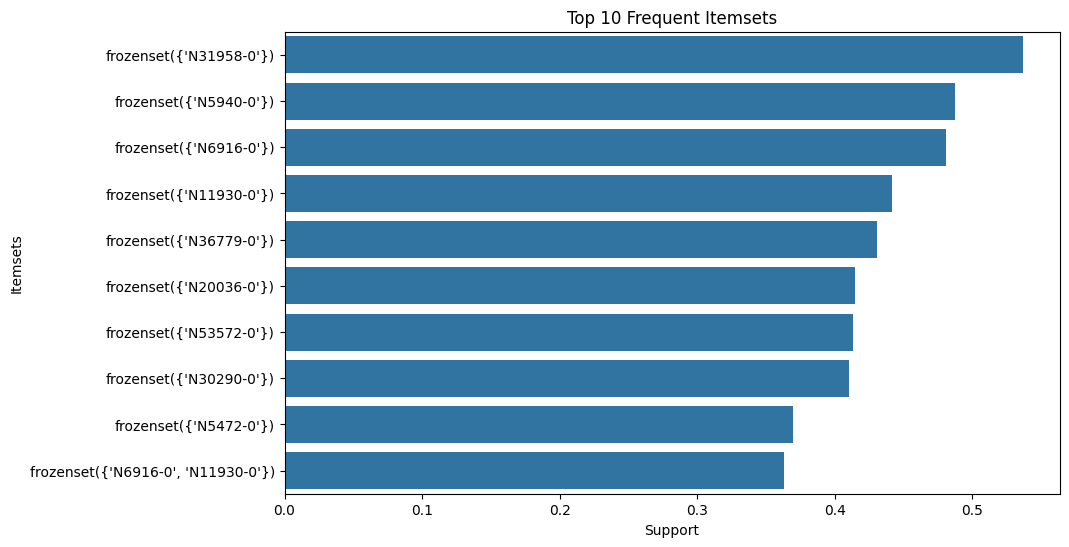

In [2]:
# 1. 数据获取与预处理
# 数据预处理：处理时间和历史记录
behaviors['time'] = pd.to_datetime(behaviors['time'])
# 处理history和impressions列的缺失值
behaviors['history'] = behaviors['history'].apply(lambda x: x.split(' ') if isinstance(x, str) else [])
behaviors['impressions'] = behaviors['impressions'].apply(lambda x: x.split(' ') if isinstance(x, str) else [])

# 2. 频繁模式挖掘
# 使用apriori算法挖掘频繁项集
from mlxtend.preprocessing import TransactionEncoder

# 合并历史和impressions列
transactions = behaviors['history'] + behaviors['impressions']

# 对数据进行独热编码
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# 2. 频繁模式挖掘
# 挖掘频繁项集（使用更高的min_support和low_memory=True）
frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True)

# 3. 对挖掘结果进行分析
# 查看频繁项集
print(frequent_itemsets.head())

# 4. 可视化展示
# 绘制频繁项集的支持度分布
plt.figure(figsize=(10, 6))
sns.barplot(x='support', y='itemsets', data=frequent_itemsets.nlargest(10, 'support'))
plt.title('Top 10 Frequent Itemsets')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.show()

In [5]:
# 生成关联规则
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.7)

# 查看关联规则
print(rules.head())


  antecedents consequents  antecedent support  consequent support   support  \
0  (N11390-0)  (N29862-0)            0.110961            0.352485  0.101515   
1  (N12320-0)  (N11930-0)            0.136893            0.441328  0.121788   
2  (N12446-0)  (N11930-0)            0.182797            0.441328  0.152887   
3  (N14637-0)  (N11930-0)            0.133476            0.441328  0.107010   
4  (N16120-0)  (N11930-0)            0.129580            0.441328  0.104303   

   confidence      lift  leverage  conviction  zhangs_metric  
0    0.914870  2.595485  0.062403    7.606190       0.691438  
1    0.889654  2.015859  0.061373    5.062937       0.583860  
2    0.836375  1.895133  0.072214    3.414336       0.577987  
3    0.801721  1.816611  0.048104    2.817602       0.518767  
4    0.804937  1.823899  0.047116    2.864064       0.518972  


In [10]:
# 从news数据集中创建项ID到名称的映射字典
item_id_to_name = dict(zip(news['id'], news['title']))

# 映射关联规则中的项ID到名称
rules['antecedents_name'] = rules['antecedents'].apply(lambda x: [item_id_to_name[i.split("-")[0]] for i in x])
rules['consequents_name'] = rules['consequents'].apply(lambda x: [item_id_to_name[i.split("-")[0]] for i in x])

# 查看映射后的关联规则
print(rules[['antecedents_name', 'consequents_name', 'confidence', 'lift']])


                                        antecedents_name  \
0      [Police find 26 children behind false wall at ...   
1      [The Coolest Way to See NYC Is in a Vintage Ca...   
2      [Homeless woman living in SUV with dogs moves ...   
3      [After Saugus High School shooting, prayer uni...   
4      [Stephanie Parze's Car Is at Home. So Is Her P...   
...                                                  ...   
93907  [Taylor Swift Rep Hits Back at Big Machine, Cl...   
93908  [Taylor Swift Rep Hits Back at Big Machine, Cl...   
93909  [13 Reasons Why's Christian Navarro Slams Disn...   
93910  [13 Reasons Why's Christian Navarro Slams Disn...   
93911  [Taylor Swift Rep Hits Back at Big Machine, Cl...   

                                        consequents_name  confidence      lift  
0      [66 Cool Tech Gifts Anyone Would Be Thrilled t...    0.914870  2.595485  
1      [The most talked about movie moments of the 20...    0.889654  2.015859  
2      [The most talked about movie 

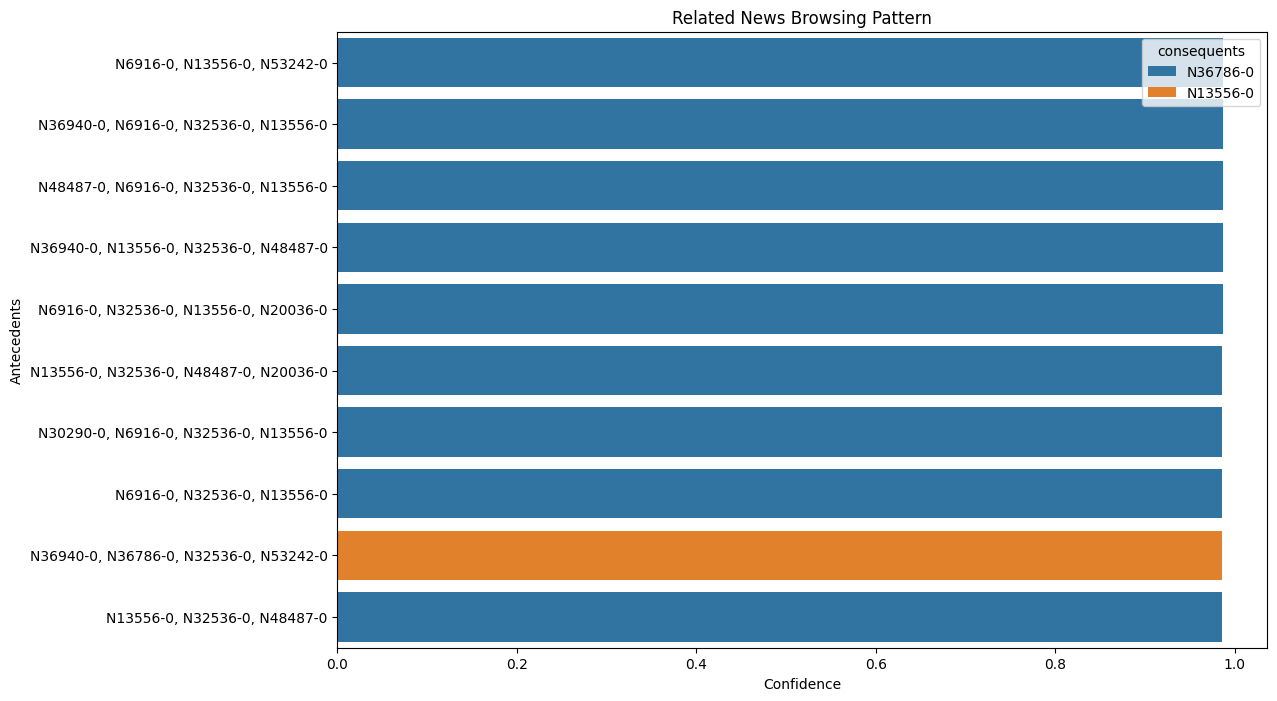

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# 排序关联规则，选择前N个规则进行可视化
N = 10
top_rules = rules.sort_values(by='confidence', ascending=False).head(N)

# 创建柱状图
plt.figure(figsize=(12, 8))
sns.barplot(x='confidence', y=top_rules['antecedents'].apply(lambda x: ', '.join(x)), 
            hue=top_rules['consequents'].apply(lambda x: ', '.join(x)), 
            data=top_rules)
#这个规则描述了当某个新闻或类别出现时，与之关联的另一个新闻或类别也会出现的概率很高，所以如下起名
plt.title('Related News Browsing Pattern')
plt.xlabel('Confidence')
plt.ylabel('Antecedents')
plt.show()

In [22]:


# 创建格式化的规则描述
rules['rule_description'] = rules.apply(lambda row: 
                                        '浏览过新闻 "{}" ---> 容易浏览新闻 "{}"'
                                        .format('、'.join(row['antecedents_name']), 
                                                '、'.join(row['consequents_name'])), 
                                        axis=1)
# 设置显示设置，以显示完整的列宽
pd.set_option('display.max_colwidth', None)
# 显示规则描述
print(rules[['rule_description']].head(10))

                                                                                                                                                   rule_description
0                       浏览过新闻 "Police find 26 children behind false wall at Colorado day care" ---> 容易浏览新闻 "66 Cool Tech Gifts Anyone Would Be Thrilled to Receive"
1  浏览过新闻 "The Coolest Way to See NYC Is in a Vintage Car From the Roaring '20s on This Midtown Tour" ---> 容易浏览新闻 "The most talked about movie moments of the 2010s"
2          浏览过新闻 "Homeless woman living in SUV with dogs moves into apartment with community's help" ---> 容易浏览新闻 "The most talked about movie moments of the 2010s"
3                      浏览过新闻 "After Saugus High School shooting, prayer unites a grieving community" ---> 容易浏览新闻 "The most talked about movie moments of the 2010s"
4                      浏览过新闻 "Stephanie Parze's Car Is at Home. So Is Her Phone. But She's Missing." ---> 容易浏览新闻 "The most talked about movie moments of the 2010s"
5               

二、选取了SNAP中Higgs Twitter Dataset数据集

higgs-activity_time.txt 数据集看起来包含用户活动的时间戳记录，每一行由四个字段组成：

第一个字段可能是用户的ID或活动的唯一标识符。
第二个字段可能是另一个用户的ID或与活动相关的其他实体。
第三个字段是时间戳，可能表示活动发生的时间（UNIX时间戳）。
第四个字段可能是活动的类型或分类（MT、RE、RT等）。

1.数据预处理
在进行频繁模式挖掘之前，我们需要对数据进行预处理。预处理可能包括以下几个步骤：

  数据清洗：去除重复行或无效数据。
  特征提取：根据挖掘任务的需要，提取有用的特征，如用户ID、活动类型、时间窗口等。

In [16]:
import pandas as pd  
from mlxtend.preprocessing import TransactionEncoder  
from mlxtend.frequent_patterns import apriori, association_rules  
import matplotlib.pyplot as plt  
  
# 加载数据  
data = pd.read_csv('higgs-activity_time.txt', sep=' ', header=None, names=['user_id', 'related_id', 'timestamp', 'activity_type'])  
# 假设我们只关心活动类型，并且想找出活动类型之间的关联  
activity_types = data['activity_type'].unique()  
te = TransactionEncoder()  
te_ary = te.fit(activity_types).transform(data['activity_type'])  
df = pd.DataFrame(te_ary, columns=te.columns_)  

2.频繁模式挖掘
对于该数据集，我们可以考虑以下几种类型的频繁模式挖掘：

  用户活动频繁模式：找出哪些用户在特定时间段内频繁进行某种类型的活动。
  活动类型频繁模式：分析哪些活动类型在特定时间段内频繁发生。
  用户间交互频繁模式：分析用户间的交互模式，如哪些用户频繁地与其他用户进行某种类型的活动。

In [17]:
# 频繁项集挖掘  
frequent_itemsets = apriori(df, min_support=0.05, use_colnames=True)

3.关联规则挖掘
关联规则挖掘可以帮助我们发现用户活动之间的关联关系。

In [18]:
# 关联规则挖掘  
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

In [19]:
# 打印结果  
print("频繁项集:")  
print(frequent_itemsets)  
  
print("\n关联规则:")  
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

频繁项集:
    support itemsets
0  0.065537      (E)
1  0.304114      (M)
2  0.695886      (R)
3  0.934463      (T)
4  0.065537   (E, R)
5  0.304114   (T, M)
6  0.630349   (R, T)

关联规则:
  antecedents consequents   support  confidence      lift
0         (E)         (R)  0.065537    1.000000  1.437016
1         (M)         (T)  0.304114    1.000000  1.070134
2         (R)         (T)  0.630349    0.905822  0.969350


4.模式命名
对于频繁项集，我们可以直接根据项集中的元素进行命名。例如：

{E} 可以命名为 "单独购买E" 或 "E的单独购买"
{M} 可以命名为 "单独购买M" 或 "M的单独购买"
{R} 可以命名为 "单独购买R" 或 "R的单独购买"
{T} 可以命名为 "单独购买T" 或 "T的单独购买"
{R, E} 可以命名为 "R和E的联合购买" 或 "同时购买R和E"
{M, T} 可以命名为 "M和T的联合购买" 或 "同时购买M和T"
{R, T} 可以命名为 "R和T的联合购买" 或 "同时购买R和T"
关联规则命名
对于关联规则，我们可以使用“如果...那么...”的语句进行命名。例如：

E -> R 可以命名为 "如果购买了E，那么也会购买R"
M -> T 可以命名为 "如果购买了M，那么也会购买T"
R -> T 可以命名为 "如果购买了R，那么也可能会购买T"
根据输出结果，我们可以命名如下：

频繁项集命名：
E的单独购买：支持度为0.065537的项集(E)
M的单独购买：支持度为0.304114的项集(M)
R的单独购买：支持度为0.695886的项集(R)
T的单独购买：支持度为0.934463的项集(T)
R和E的联合购买：支持度为0.065537的项集(R, E)
M和T的联合购买：支持度为0.304114的项集(M, T)
R和T的联合购买：支持度为0.630349的项集(R, T)
关联规则命名：
如果购买了E，则也会购买R：置信度为1.000000，提升度为1.437016的规则(E -> R)
如果购买了M，则也会购买T：置信度为1.000000，提升度为1.070134的规则(M -> T)
如果购买了R，则可能也会购买T：置信度为0.905822，提升度为0.969350的规则(R -> T)

5.可视化

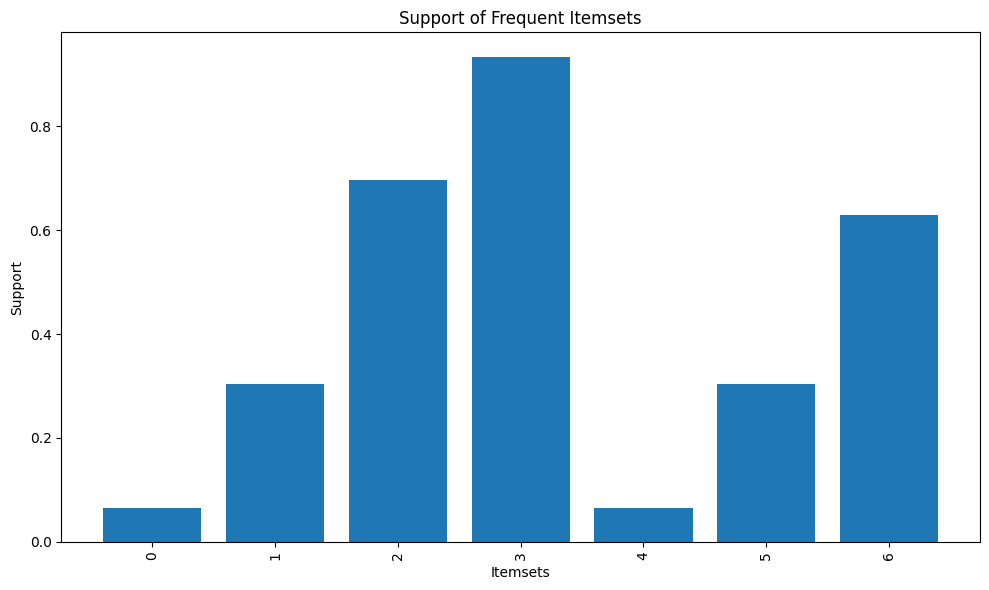

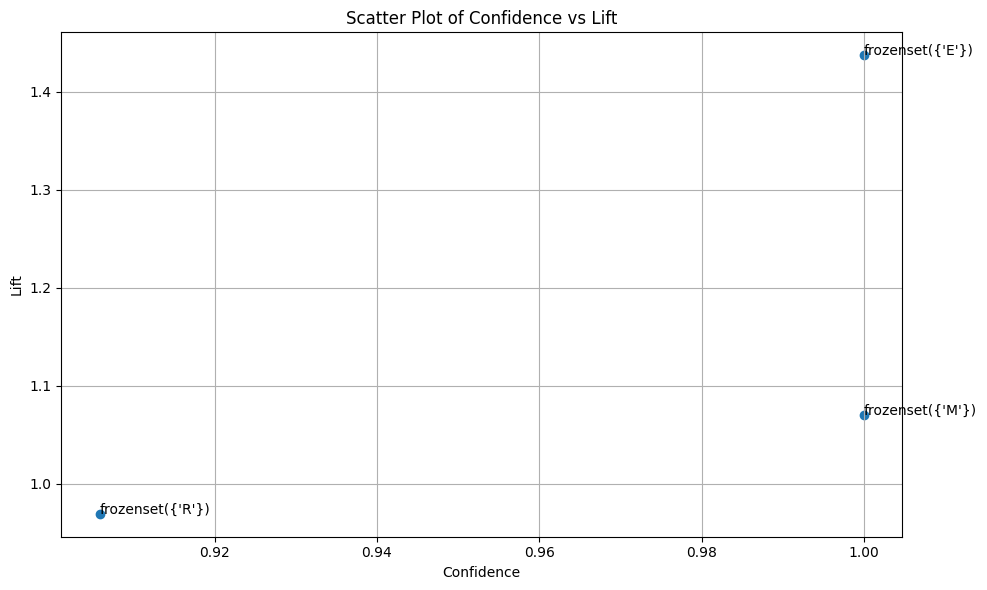

In [5]:
import matplotlib.pyplot as plt  
  
# 频繁项集可视化：支持度排序并绘制条形图  
frequent_itemsets_sorted = frequent_itemsets.sort_values(by='support', ascending=False)  
plt.figure(figsize=(10, 6))  
plt.bar(frequent_itemsets_sorted.index, frequent_itemsets_sorted['support'])  
plt.xlabel('Itemsets')  
plt.ylabel('Support')  
plt.title('Support of Frequent Itemsets')  
plt.xticks(rotation=90)  # 如果项集名称过长，可以旋转x轴标签以便阅读  
plt.tight_layout()  
plt.show()  
  
# 关联规则可视化：置信度与提升度的散点图  
plt.figure(figsize=(10, 6))  
plt.scatter(rules['confidence'], rules['lift'])  
plt.xlabel('Confidence')  
plt.ylabel('Lift')  
plt.title('Scatter Plot of Confidence vs Lift')  
for i, txt in enumerate(rules['antecedents']):  
    plt.annotate(txt, (rules['confidence'][i], rules['lift'][i]))  
plt.grid(True)  
plt.tight_layout()  
plt.show()